In [35]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
time_step = 100
input_num = 100
adjust_steps = 200

tau_i_input = 2*np.ones(input_num)
tau_i_output = 2
tau_u = 5

i_input_decay = (1-1/tau_i_input)
i_output_decay = (1-1/tau_i_output)
u_decay = (1-1/tau_u)

In [36]:
def smooth(x, decay):
    if len(x.shape)==1:
        x = x.reshape(1,len(x))
    x = x.astype(float)
    x_smooth = np.zeros_like(x)
    x_smooth[:,0]=x[:,0]/(1/(1-decay))
    for i in range(len(x[0])-1):
        x_smooth[:,i+1] = x_smooth[:,i]*decay + x[:,i+1].astype(float)/(1/(1-decay))
    return x_smooth

In [37]:
def sigmoid(x,temp):
    exp = np.clip(-x/temp, -10, 10)
    return 1 / (1 + np.exp(exp))

In [38]:
output_record = np.zeros((adjust_steps, time_step))
output_smooth_record = np.zeros((adjust_steps, time_step))
u_record = np.zeros((adjust_steps, time_step))
loss_record = np.zeros(adjust_steps)
tau_u_record = np.zeros(adjust_steps)
u_decay_record = np.zeros(adjust_steps)
i_decay_record = np.zeros(adjust_steps)
u = np.zeros(time_step)
output = np.zeros(time_step)

In [39]:
partial_a = np.zeros((time_step, time_step))
for t in range(time_step):
    if t > 0:
        partial_a[t] = partial_a[t - 1] - partial_a[t - 1] / tau_i_output
    partial_a[t, t] = 1/tau_i_output

In [40]:
def figs_plot(plot_flag):
    if plot_flag:
        plt.figure()
        plt.plot(loss_record)
        plt.figure(figsize=(9,5*adjust_steps/time_step/2))

        plt.subplot(131)
        plt.imshow(output_record, cmap='cividis')
        for i,o in enumerate(desired_output[0]):
            if o == 1:
                plt.plot((i,i),(0,adjust_steps-1),c='r',alpha=.5)
    #     plt.figure(figsize=(5,5*adjust_steps/time_step))
        plt.subplot(132)
        plt.imshow(output_smooth_record, cmap='cividis')
        for i,o in enumerate(desired_output[0]):
            if o == 1:
                plt.plot((i,i),(0,adjust_steps-1),c='r',alpha=.5)

    #     plt.figure(figsize=(5,5*adjust_steps/time_step))
        plt.subplot(133)
        plt.imshow(np.clip(u_record,0,10), cmap='cividis')
        for i,o in enumerate(desired_output[0]):
            if o == 1:
                plt.plot((i,i),(0,adjust_steps-1),c='r',alpha=.5)
def prepare_plot(plot_flag):
    if plot_flag:
        plt.figure()
        global u_fig
        u_fig = plt.axes()
        plt.title("Membrane Potential")

        plt.figure()
        global delta_fig
        delta_fig = plt.axes()
        plt.title('Delta')

        plt.figure()
        global grad_fig
        grad_fig = plt.axes()
        plt.title('Grad')

In [41]:
threshold = 1
lr = 0.003
temp = 0.2

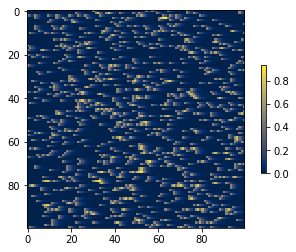

In [42]:
a = np.random.randint(0,10, size=(input_num,time_step))
a = (a==0).astype(float)
a_smooth = smooth(a, i_input_decay)
plt.figure(figsize=(6,4))
plt.imshow(a_smooth, cmap='cividis')
plt.colorbar(shrink=.5)

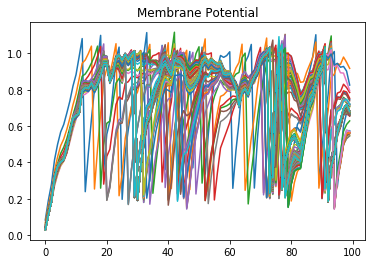

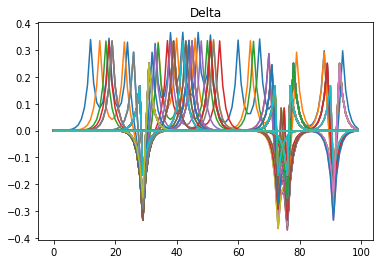

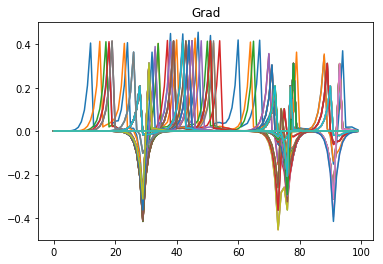

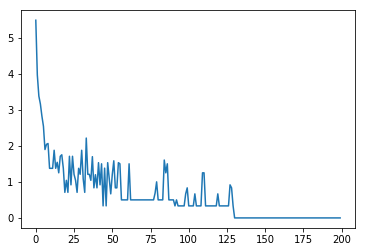

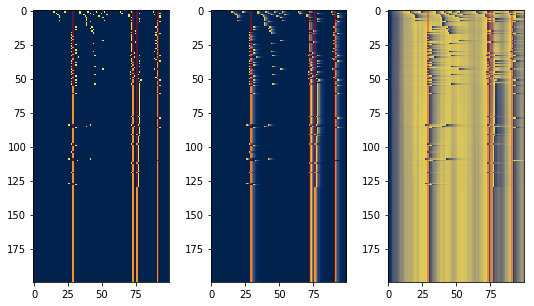

In [47]:
weights = np.random.random(size=input_num) *0.05
desired_output = np.random.randint(0,20,size=(1,time_step))
desired_output = (desired_output == 0).astype(float)
desired_output_smooth = smooth(desired_output, i_output_decay)

# If plot needed, set plot_flag = True
plot_flag = True
prepare_plot(plot_flag)

tau_i_input = 2*np.ones(input_num)
tau_i_output = 2
tau_u = 5

i_input_decay = (1-1/tau_i_input)
i_output_decay = (1-1/tau_i_output)
u_decay = (1-1/tau_u)

for i in range(adjust_steps):
    # Forward
    output = np.zeros(time_step)
    u[0] = u_temp = np.dot(weights, a_smooth[:,0])
    if u[0] > threshold:
        u_temp = 0
        output[0] = 1
    for j in range(time_step-1):
        u[j+1] = u_temp * u_decay + np.dot(weights,a_smooth[:,j+1])
        if u[j+1] > threshold:
            u_temp = 0
            output[j+1] = 1
        else:
            u_temp = u[j+1]
    output_smooth = smooth(output, i_output_decay)
    

    # Record status
    output_record[i] = output
    output_smooth_record[i] = output_smooth
    u_record[i] = u
    u_decay_record[i] = u_decay
    
    # Backward
    # Calculate weight's gradient
    delta = (output_smooth-desired_output_smooth)[0].dot(partial_a)
    loss_record[i] = np.sum((output_smooth-desired_output_smooth)[0]**2)
    sig = sigmoid(u-threshold, temp)
    grad = delta*(sig*(1-sig))/temp
    grad_w = grad.dot(a_smooth.T)
    
    # Calculate input's gradient
    grad_a = np.zeros_like(a_smooth)
    for t in range(time_step):
        grad_a[:, t] = grad[t]*weights.T

    if plot_flag:
        u_fig.plot(u)
        delta_fig.plot(delta)
        grad_fig.plot(grad)
    
    # Move Step
    weights = weights - lr * grad_w 
figs_plot(plot_flag)